In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
#Aim 1 - look at allele frequencies in 756 cells from RN that have at least 100 reads for each of 4 amplicons - not in this notebook
#Aim 2 - practise dataframe manipulation so I'm not constantly making sub-frames and tying myself in knots - mostly this

In [31]:
#Import all the data again
#Import the data and flip into a multi index 
df = pd.read_csv('../Data/allele_counts.tsv', header = [0,1,2], index_col = 0, sep='\t')
df = df.stack([0,1,2])
df = df.reorder_levels([1,0,2,3])
df = df.to_frame()  #puts everything back in a dataframe
df.columns = ['Reads']
df['Plate'] = df.index.get_level_values(0)  #These lines send indexes to columns
df['Well'] = df.index.get_level_values(1)
df['Amplicon'] = df.index.get_level_values(2)
df['Genotype'] = df.index.get_level_values(3)
df[['Patient', 'one', 'two']] = df['Amplicon'].str.split('_', expand = True)
df = df.drop(columns = ['one', 'two'])
#print(df.shape[0]) #shape of the df in the height dimension
#df

In [330]:
#Need to be able to assign patient and cell type from the plate ID

#Import information about plate cell type and patient
key = pd.read_excel('../Data/Amplicon_metadata_fixed.xlsx', sheet_name = 'PlateID')
key = key.drop(['Cell Origin', 'Plate Nr', 'Plate Name','Nr of cells', 'fcs-fle' ], axis=1)
key.rename(columns = {'Comments2':'Plate'}, inplace = True)
key.rename(columns = {'Cell-group':'Celltype'}, inplace = True)

#Make a dictionary to associate plates with patients and plate with cell type
plate_pt_dict = dict(zip(key.Plate, key.Patient))
plate_cell_dict = dict(zip(key.Plate, key.Celltype))



In [6]:
#Set up some lists for iteration
patients = ['RN', 'EL', 'GR']
plates = df['Plate'].drop_duplicates().to_list()
amplicons = df['Amplicon'].drop_duplicates().to_list()
genos = df['Genotype'].drop_duplicates().to_list()
wells = df['Well'].drop_duplicates().to_list()

In [32]:
#Reads per well per plate
read_plate = df.groupby(['Plate', 'Well']).sum()
read_plate = read_plate.reset_index()
read_plate['Number'] = read_plate['Well'].str.replace('([A-Z]+)', '')
read_plate['Letter'] = read_plate['Well'].str.extract('([A-Z]+)')
read_plate = read_plate.drop(columns = ['Well'])
#read_plate

,Plate,Reads,Number,Letter
0,AS-187,247.0,1,A
1,AS-187,7.0,10,A
2,AS-187,396.0,11,A
3,AS-187,187.0,12,A
4,AS-187,209.0,13,A
...,...,...,...,...
10363,AS-223,20.0,5,P
10364,AS-223,519.0,6,P
10365,AS-223,201.0,7,P
10366,AS-223,352.0,8,P


In [8]:
#plot reads per plate 
fig, axs = plt.subplots(9,3, figsize = (16, 18))
fig.subplots_adjust(hspace = 1, wspace=.2)
axs = axs.ravel()

count = -1

for plate in plates:
    
    j = plate_pt_dict.get(plate) #use the dict to make a variable that contains the patient name for the current plate
    m = plate_cell_dict.get(plate) #use the dict to make a variable that contains the cell ype for the current plate    
        
    count = count + 1
    a = read_plate.loc[read_plate['Plate'].isin([plate])]
    a = a.pivot(index = 'Letter', columns = 'Number', values = 'Reads')
    #Re-order data here to get proper plate layout
    a = np.minimum(a, 100)    
                       
    axs[count] = sns.heatmap(a, cmap = 'YlGnBu_r', ax = axs[count])#Plot the data on the next ax
    axs[count].set_title(str(plate+' '+j+' '+m)) #set title to contain plate and cell type

fig.suptitle('Total reads per well/per plate (max100)', fontsize=16)
#fig.savefig('../Results/Well_counts/well_counts_total_max100.png',dpi=600)  

plt.close() #Plot just goes to file and isn't displayed

In [9]:
#Reads per amplicon per well per plate
#Makes sense to split into patients at this point
amps_plate = df.groupby(['Plate', 'Well', 'Amplicon', 'Patient']).sum() #group by plate, well, amplicon, patient
amps_plate['Patient'] = amps_plate.index.get_level_values(3) #Put patient ID back into a column

RN_amps_plate = amps_plate.loc[amps_plate['Patient'].isin(['RN'])]
RN_amps_plate = RN_amps_plate.drop(columns = 'Patient') #Remove patient column
RN_amps_plate = RN_amps_plate.unstack(level = 2) #unstack to split amplicons into columns

EL_amps_plate = amps_plate.loc[amps_plate['Patient'].isin(['EL'])]
EL_amps_plate = EL_amps_plate.drop(columns = 'Patient')  #Remove patient column
EL_amps_plate = EL_amps_plate.unstack(level = 2) #unstack to split amplicons into columns

GR_amps_plate = amps_plate.loc[amps_plate['Patient'].isin(['GR'])]
GR_amps_plate = GR_amps_plate.drop(columns = 'Patient')  #Remove patient column
GR_amps_plate = GR_amps_plate.unstack(level = 2) #unstack to split amplicons into columns

#Check there's data for 9 x 384 = 3456 wells
print(RN_amps_plate.shape[0])
print(EL_amps_plate.shape[0])
print(GR_amps_plate.shape[0])

3456
3456
3456


In [120]:
#Just look at RN now

#Looking at all amplicons

cells100 = RN_amps_plate.loc[(RN_amps_plate >= 100).all(axis=1)]
cells50 = RN_amps_plate.loc[(RN_amps_plate >= 50).all(axis=1)]
cells10 = RN_amps_plate.loc[(RN_amps_plate >= 10).all(axis=1)]

one = ('Looking at all 6 amplicons;'
    'Cells with at least 10 reads per amplicon = ' + str(cells10.shape[0]),
    'Cells with at least 50 reads per amplicon = ' + str(cells50.shape[0]),
    'Cells with at least 100 reads per amplicon = ' + str(cells100.shape[0]))


#Now excluding TET2b amplicons
RN_some_amps_plate = RN_amps_plate.iloc[: , 0:4]


somecells100 = RN_some_amps_plate.loc[(RN_some_amps_plate >= 100).all(axis=1)]
somecells50 = RN_some_amps_plate.loc[(RN_some_amps_plate >= 50).all(axis=1)]
somecells10 = RN_some_amps_plate.loc[(RN_some_amps_plate >= 10).all(axis=1)]

two = ('Looking at 4 amplicons (not TET2b);'
    'Cells with at least 10 reads per amplicon = ' + str(somecells10.shape[0]),
    'Cells with at least 50 reads per amplicon  = ' + str(somecells50.shape[0]),
    'Cells with at least 100 reads per amplicon = ' + str(somecells100.shape[0]))


print(one, two)

('Looking at all 6 amplicons;Cells with at least 10 reads per amplicon = 0', 'Cells with at least 50 reads per amplicon = 0', 'Cells with at least 100 reads per amplicon = 0') ('Looking at 4 amplicons (not TET2b);Cells with at least 10 reads per amplicon = 2149', 'Cells with at least 50 reads per amplicon  = 1178', 'Cells with at least 100 reads per amplicon = 756')


In [11]:
#Plotting the read distributions
#All amplicons
x = np.logspace(0, 3, 50)   #sets the axis space - returns from log 0 to log 3 in 50 equal increments
y = [RN_amps_plate.loc[(RN_amps_plate >= xi).all(axis=1)].shape[0] for xi in x] #This filters the df to contain the number 
#of cells (rows) that meet each iteration, and shape[0] essentially returns the number of rows (ie/ the dimension on axis = 0)
fig, ax = plt.subplots()
ax.plot(x, y, color = 'red')
ax.set_yscale('log')
ax.set_xscale('log')
ax.axvline(10, ls = '--')
ax.axvline(100, ls = '--')
ax.axhline(2200, ls = '--')
ax.axhline(780, ls = '--')
ax.set_xlabel('Number of reads')
ax.set_ylabel('Number of cells')

fig.suptitle('RN - cells with >x reads for all amplicons', fontsize=16)        
#fig.savefig('../Results/Amp_counts/RN_amp_counts_per_cell_all_amplicons.png',dpi=600) 
plt.close() #Plot just goes to file and isn't displayed

In [121]:
#Plotting the read distributions
#Amplicons except TET2b
x = np.logspace(0, 3, 50)   #sets the axis space - returns from log 0 to log 3 in 50 equal increments
y = [RN_some_amps_plate.loc[(RN_some_amps_plate >= xi).all(axis=1)].shape[0] for xi in x] #This filters the df to contain the number 
#of cells (rows) that meet each iteration, and shape[0] essentially returns the number of rows (ie/ the dimension on axis = 0)
fig, ax = plt.subplots()
ax.plot(x, y, color = 'red')
ax.set_yscale('log')
ax.set_xscale('log')
ax.axvline(10, ls = '--')
ax.axvline(100, ls = '--')
ax.axhline(2200, ls = '--')
ax.axhline(780, ls = '--')
ax.set_xlabel('Number of reads')
ax.set_ylabel('Number of cells')

fig.suptitle('RN - cells with >x reads for amplicons except TET2b', fontsize=16)        
fig.savefig('../Results/Amp_counts/RN_amp_counts_per_cell_amplicons_except TET2b.png',dpi=600) 
plt.close() #Plot just goes to file and isn't displayed

In [13]:
#Iterable lists of amplicons from column headers
#Bad solution, ended up with labels in the wrong order
EL_col = [] #Make empty lists
GR_col = []
RN_col = []

col_headers = list(EL_amps_plate.columns.levels[1]) #Grabs the column headers from multi index
for x in col_headers:
    if 'EL' in x:
        EL_col.append(x)

col_headers = list(GR_amps_plate.columns.levels[1]) #Grabs the column headers from multi index
for x in col_headers:
    if 'GR' in x:
        GR_col.append(x)  
        
col_headers = list(RN_amps_plate.columns.levels[1]) #Grabs the column headers from multi index
for x in col_headers:
    if 'RN' in x:
        RN_col.append(x) 

In [14]:
#Plot each individual amplicon for RN
fig, ax = plt.subplots(2,3, figsize = (16, 8))
fig.subplots_adjust(hspace = 1, wspace=.5)
ax = ax.ravel()
count = -1

for z in range(6):
    count = count + 1
    data = RN_amps_plate.iloc[: , z].to_frame()
    x = np.logspace(0, 3, 50)   #sets the axis space - returns from log 0 to log 3 in 50 equal increments
    y = [data.loc[(data >= xi).all(axis=1)].shape[0] for xi in x] #This filters the df to contain the number 
#of cells (rows) that meet each iteration, and shape[0] essentially returns the number of rows (ie/ the dimension on axis = 0)
    
    a = data.columns.levels[1]
    
    ax[count].plot(x, y, color = 'red')
    ax[count].set_yscale('log')
    ax[count].set_xscale('log')
    ax[count].axvline(10, ls = '--')
    ax[count].axvline(100, ls = '--')
    #ax[count].axhline(2200, ls = '--')
    #ax[count].axhline(780, ls = '--')
    ax[count].set_xlabel('Number of reads')
    ax[count].set_ylabel('Number of cells')
    ax[count].set_title('Amplicon = ' + a)
    
fig.suptitle('RN - cells with >x per amplicon', fontsize=16)        
#fig.savefig('../Results/Amp_counts/RN_amp_counts_per_cell_per_amplicons.png',dpi=600) 
plt.close() #Plot just goes to file and isn't displayed

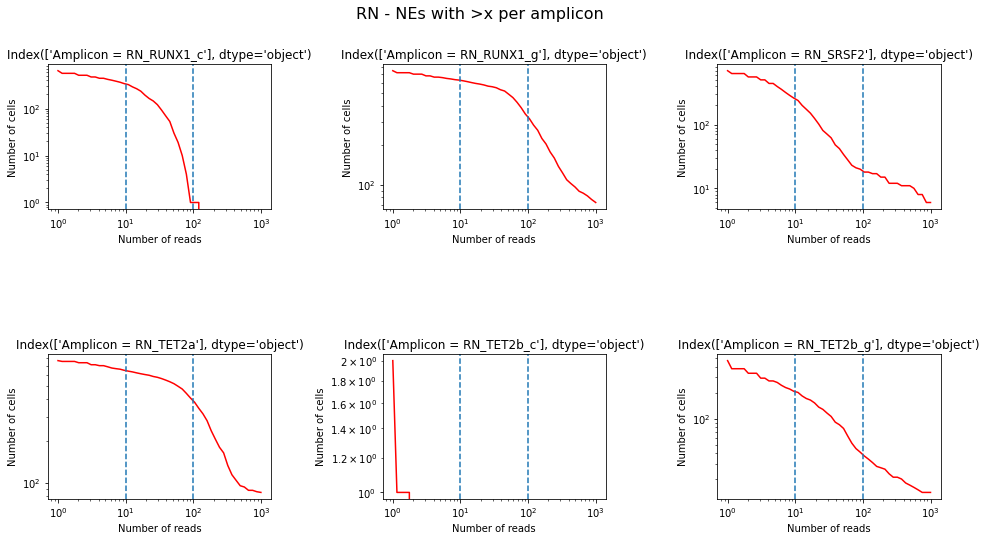

In [481]:
#Plot each individual amplicon for RN neutrophils (no cells met our criteria)
RN_amps_NE = RN_amps_plate
RN_amps_NE['Plate'] = RN_amps_NE.index.get_level_values(0)
RN_amps_NE = RN_amps_NE[RN_amps_NE['Plate'].isin(['AS-195', 'AS-189'])]

fig, ax = plt.subplots(2,3, figsize = (16, 8))
fig.subplots_adjust(hspace = 1, wspace=.5)
ax = ax.ravel()
count = -1

for z in range(6):
    count = count + 1
    data = RN_amps_NE.iloc[: , z].to_frame()
    x = np.logspace(0, 3, 50)   #sets the axis space - returns from log 0 to log 3 in 50 equal increments
    y = [data.loc[(data >= xi).all(axis=1)].shape[0] for xi in x] #This filters the df to contain the number 
#of cells (rows) that meet each iteration, and shape[0] essentially returns the number of rows (ie/ the dimension on axis = 0)
    
    a = data.columns.levels[1]
    
    ax[count].plot(x, y, color = 'red')
    ax[count].set_yscale('log')
    ax[count].set_xscale('log')
    ax[count].axvline(10, ls = '--')
    ax[count].axvline(100, ls = '--')
    #ax[count].axhline(2200, ls = '--')
    #ax[count].axhline(780, ls = '--')
    ax[count].set_xlabel('Number of reads')
    ax[count].set_ylabel('Number of cells')
    ax[count].set_title('Amplicon = ' + a)
    
fig.suptitle('RN - NEs with >x per amplicon', fontsize=16)        
fig.savefig('../Results/Amp_counts/RN_amp_counts_per_cell_per_amplicons_NEs.png',dpi=600) 
#plt.close() #Plot just goes to file and isn't displayed

In [15]:
#Plot each individual amplicon for EL
fig, ax = plt.subplots(2,3, figsize = (16, 8))
fig.subplots_adjust(hspace = 1, wspace=.5)
ax = ax.ravel()
count = -1

for z in range(6):
    count = count + 1
    data = EL_amps_plate.iloc[: , z].to_frame()
    x = np.logspace(0, 3, 50)   #sets the axis space - returns from log 0 to log 3 in 50 equal increments
    y = [data.loc[(data >= xi).all(axis=1)].shape[0] for xi in x] #This filters the df to contain the number 
#of cells (rows) that meet each iteration, and shape[0] essentially returns the number of rows (ie/ the dimension on axis = 0)
    
    a = data.columns.levels[1]
    
    ax[count].plot(x, y, color = 'red')
    ax[count].set_yscale('log')
    ax[count].set_xscale('log')
    ax[count].axvline(10, ls = '--')
    ax[count].axvline(100, ls = '--')
    #ax[count].axhline(2200, ls = '--')
    #ax[count].axhline(780, ls = '--')
    ax[count].set_xlabel('Number of reads')
    ax[count].set_ylabel('Number of cells')
    ax[count].set_title('Amplicon = ' + a)
    
fig.suptitle('EL - cells with >x per amplicon', fontsize=16)        
#fig.savefig('../Results/Amp_counts/EL_amp_counts_per_cell_per_amplicons.png',dpi=600) 
plt.close() #Plot just goes to file and isn't displayed

In [16]:
#Plot each individual amplicon for GR
fig, ax = plt.subplots(2,3, figsize = (16, 8))
fig.subplots_adjust(hspace = 1, wspace=.5)
ax = ax.ravel()
count = -1

for z in range(2):
    count = count + 1
    data = GR_amps_plate.iloc[: , z].to_frame()
    x = np.logspace(0, 3, 50)   #sets the axis space - returns from log 0 to log 3 in 50 equal increments
    y = [data.loc[(data >= xi).all(axis=1)].shape[0] for xi in x] #This filters the df to contain the number 
#of cells (rows) that meet each iteration, and shape[0] essentially returns the number of rows (ie/ the dimension on axis = 0)
    
    a = data.columns.levels[1]
    
    ax[count].plot(x, y, color = 'red')
    ax[count].set_yscale('log')
    ax[count].set_xscale('log')
    ax[count].axvline(10, ls = '--')
    ax[count].axvline(100, ls = '--')
    #ax[count].axhline(2200, ls = '--')
    #ax[count].axhline(780, ls = '--')
    ax[count].set_xlabel('Number of reads')
    ax[count].set_ylabel('Number of cells')
    ax[count].set_title('Amplicon = ' + a)
    
fig.suptitle('GR - cells with >x per amplicon', fontsize=16)        
#fig.savefig('../Results/Amp_counts/GR_amp_counts_per_cell_per_amplicons.png',dpi=600) 
plt.close() #Plot just goes to file and isn't displayed

In [381]:
#Start looking at alleles for RN - first identify the wells that contain cells with enough amplicons
RN_allele_plate = df.loc[df['Patient'].isin(['RN'])] #Make df with just RN data
RN_allele_plate = RN_allele_plate.drop(columns = 'Patient') #Drop the Patient ID column and other unwanted cols

#Find the cells/wells that contain >100 reads for the selected amplicons and turn into a list 
#Re-arrange the table
test = RN_allele_plate.groupby(['Plate', 'Well', 'Amplicon']).sum()
test = test.unstack()
test = test.iloc[:, 0:4] #Just keep the columns of interest
test = test.loc[(test >= 100).all(axis=1)] #test contains just the rows with cells we want - use this to create a filter or key
test.stack()
#Make the plate and well info a single column and put in a list
test['Plate'] = test.index.get_level_values(0)  #These lines send indexes to columns
test['Well'] = test.index.get_level_values(1)
test['Plate_Well'] = test['Plate'].astype(str) + '_' + test['Well'].astype(str)
RN_wells = test['Plate_Well'].to_list()
print(len(RN_wells))

756


In [382]:
#Now extract the data just for the desired cells/wells
#This could probably be coded more cleanly, but can't be bothered fixing now
test2 = RN_allele_plate
test2['Plate_Well'] = test2['Plate'].astype(str) + '_' + test2['Well'].astype(str)
test3 = test2[test2['Plate_Well'].isin(RN_wells)] #keep the wells identified before
test3 = test3[test3['Amplicon'].isin(['RN_RUNX1_c', 'RN_RUNX1_g', 'RN_SRSF2', 'RN_TET2a'] )] #keep the amplicons that worked
test3 #Sub df with just the numbers of interest  

Reads   Plate Well    Amplicon Genotype  Plate_Well
AS-194 A13 RN_RUNX1_c MT     0.0  AS-194  A13  RN_RUNX1_c       MT  AS-194_A13
                      WT   160.0  AS-194  A13  RN_RUNX1_c       WT  AS-194_A13
           RN_RUNX1_g MT     1.0  AS-194  A13  RN_RUNX1_g       MT  AS-194_A13
                      WT  2603.0  AS-194  A13  RN_RUNX1_g       WT  AS-194_A13
           RN_SRSF2   MT     2.0  AS-194  A13    RN_SRSF2       MT  AS-194_A13
...                          ...     ...  ...         ...      ...         ...
AS-198 P20 RN_RUNX1_g WT   275.0  AS-198  P20  RN_RUNX1_g       WT  AS-198_P20
           RN_SRSF2   MT   111.0  AS-198  P20    RN_SRSF2       MT  AS-198_P20
                      WT    28.0  AS-198  P20    RN_SRSF2       WT  AS-198_P20
           RN_TET2a   MT    19.0  AS-198  P20    RN_TET2a       MT  AS-198_P20
                      WT    82.0  AS-198  P20    RN_TET2a       WT  AS-198_P20

[6048 rows x 6 columns]

In [439]:
#Calculates the allele frequency
#test5 is the df in the right format for plotting
test4 = test3
test4 = test4.iloc[:, 0:1].unstack(level = 3)
test4['Total'] = test4.iloc[: , 0] + test4.iloc[: , 1]
test4['Mut_freq'] = test4.iloc[:, 0]/test4['Total']
test5 = test4.drop(columns = ['Reads', 'Total'])
test5['Plate'] = test5.index.get_level_values(0)
test5['Amplicon'] = test5.index.get_level_values(2)
test5['Cell_type'] = test5['Plate'].replace(plate_cell_dict)
test5['Well'] = test5.index.get_level_values(1)
test5['Plate_Well'] = test5['Plate'].astype(str) + '_' + test5['Well'].astype(str)
test5.to_csv('../Results/Geno_counts/geno_counts_frequencies.tsv', index = None, sep = '\t')
test4.to_csv('../Results/Geno_counts/geno_counts_frequencies_raw_reads.tsv', index = None, sep = '\t')
#Next - reassign cell type and plot allele frequencies in total and then by cell type

In [403]:
#Make a list of cell types
#Note there are no neutrophils because the RUNX1_c amplicon isn't great (probably not expressed)
celltypes = test5['Cell_type'].drop_duplicates().to_list()
celltypes

['nBCs', 'CD34', 'CD34+/38-', 'Monocytes']

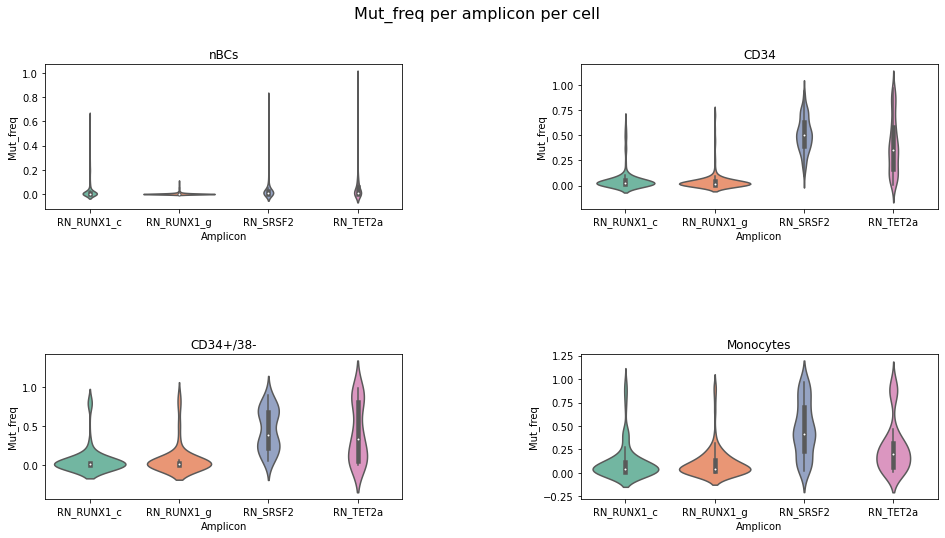

In [549]:
#Plot wells by cell type
fig, ax = plt.subplots(2,2, figsize = (16, 8))
fig.subplots_adjust(hspace = 1, wspace=.5)
ax = ax.ravel()

count = -1

for cell in celltypes:
    count = count + 1
    ax[count] = sns.violinplot(x='Amplicon', y='Mut_freq', data=test5.loc[test5['Cell_type'].isin([cell])], ax = ax[count], palette = 'Set2')
    ax[count].set_title(str(cell))
    
fig.suptitle('Mut_freq per amplicon per cell', fontsize=16)
fig.savefig('../Results/Geno_counts/All_mut_freq_per_amplicon.png',dpi=600)  

#plt.close() #Plot just goes to file and isn't displayed    

In [462]:
#let's look at cells with high frequency of TET2a mut
test6 = test5.loc[test5['Amplicon'].isin(['RN_TET2a'])].loc[test5['Mut_freq'] > 0.5]
TET2a_high = test6['Plate_Well'].to_list()

#Or TET2a low

test9 = test5.loc[test5['Amplicon'].isin(['RN_TET2a'])].loc[test5['Mut_freq'] < 0.2]
TET2a_low = test9['Plate_Well'].to_list()

#Or high freq of RUNX1_c
test7 = test5.loc[test5['Amplicon'].isin(['RN_RUNX1_c'])].loc[test5['Mut_freq'] > 0.3]
RUNX1_c_high = test7['Plate_Well'].to_list()


#Or high freq of SRSF2
test8 = test5.loc[test5['Amplicon'].isin(['RN_SRSF2'])].loc[test5['Mut_freq'] > 0.3]
SRSF2_high = test8['Plate_Well'].to_list()

In [496]:
#How about combinations?
#high RUNX_c and low TET2a
test10 = test5[test5['Plate_Well'].isin(RUNX1_c_high)]
test11 = test10[test10['Plate_Well'].isin(TET2a_low)]
TET2a_h_RUNX1_c_l = test11['Plate_Well'].to_list()

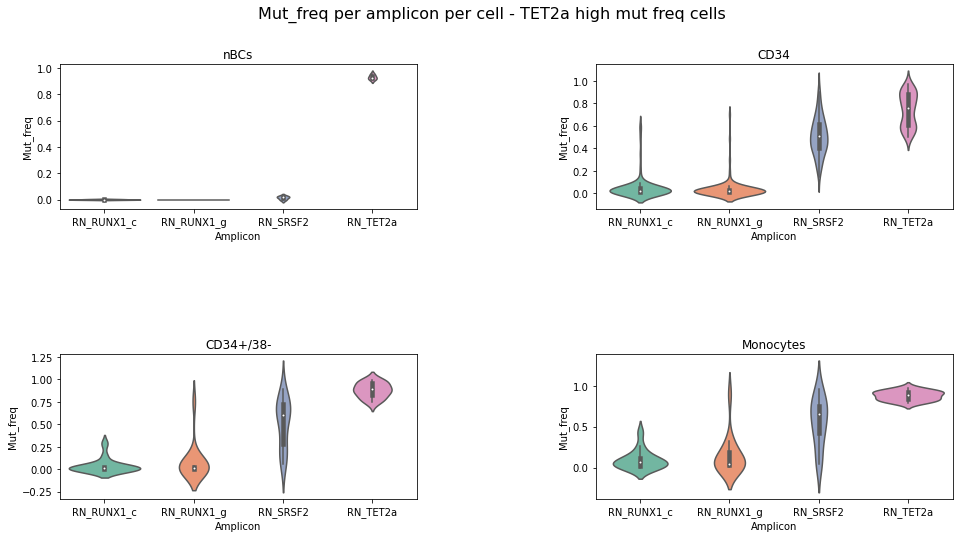

In [491]:
#Plot wells by cell type, TET2 high cells only
fig, ax = plt.subplots(2,2, figsize = (16, 8))
fig.subplots_adjust(hspace = 1, wspace=.5)
ax = ax.ravel()

count = -1

for cell in celltypes:
    count = count + 1
    ax[count] = sns.violinplot(x='Amplicon', y='Mut_freq', data=test5[test5['Plate_Well'].isin(TET2a_high)].loc[test5['Cell_type'].isin([cell])], ax = ax[count], palette = 'Set2')
    ax[count].set_title(str(cell))
    
fig.suptitle('Mut_freq per amplicon per cell - TET2a high mut freq cells', fontsize=16)
fig.savefig('../Results/Geno_counts/TET2a_high_mut_freq_per_amplicon.png',dpi=600)  

#plt.close() #Plot just goes to file and isn't displayed       

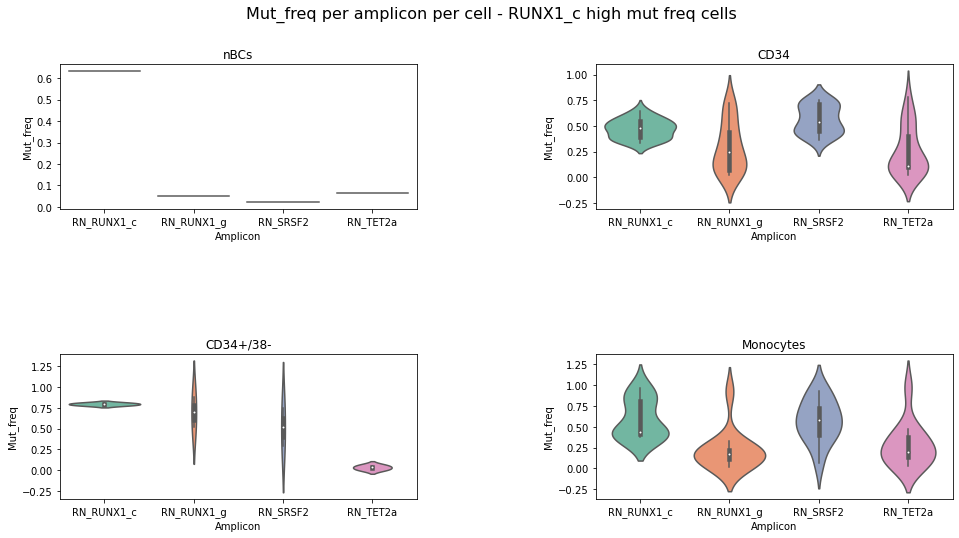

In [490]:
#Plot wells by cell type, RUNX1_g high cells only
fig, ax = plt.subplots(2,2, figsize = (16, 8))
fig.subplots_adjust(hspace = 1, wspace=.5)
ax = ax.ravel()

count = -1

for cell in celltypes:
    count = count + 1
    ax[count] = sns.violinplot(x='Amplicon', y='Mut_freq', data=test5[test5['Plate_Well'].isin(RUNX1_c_high)].loc[test5['Cell_type'].isin([cell])], ax = ax[count], palette = 'Set2')
    ax[count].set_title(str(cell))
    
fig.suptitle('Mut_freq per amplicon per cell - RUNX1_c high mut freq cells', fontsize=16)
fig.savefig('../Results/Geno_counts/RUNX1_c_high_mut_freq_per_amplicon.png',dpi=600)  

#plt.close() #Plot just goes to file and isn't displayed          

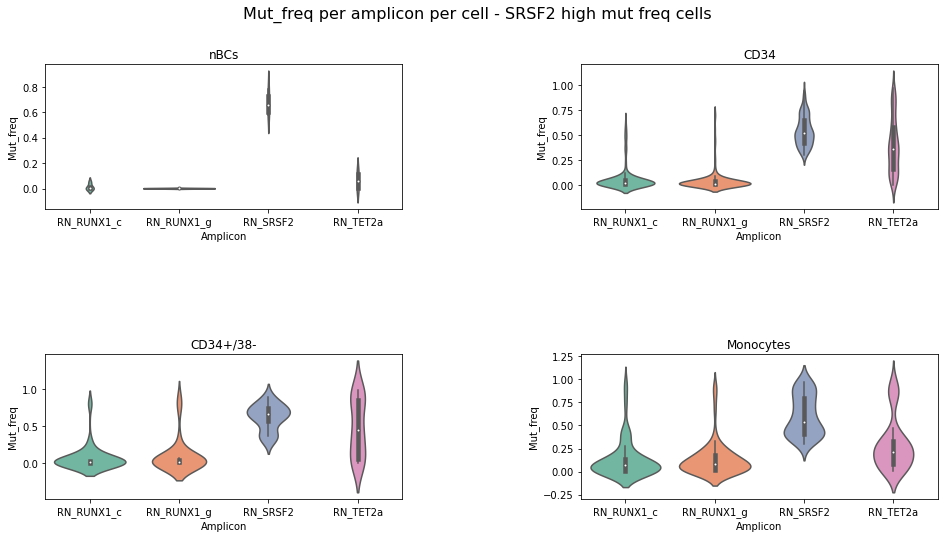

In [492]:
#Plot wells by cell type, RUNX1_g high cells only
fig, ax = plt.subplots(2,2, figsize = (16, 8))
fig.subplots_adjust(hspace = 1, wspace=.5)
ax = ax.ravel()

count = -1

for cell in celltypes:
    count = count + 1
    ax[count] = sns.violinplot(x='Amplicon', y='Mut_freq', data=test5[test5['Plate_Well'].isin(SRSF2_high)].loc[test5['Cell_type'].isin([cell])], ax = ax[count], palette = 'Set2')
    ax[count].set_title(str(cell))
    
fig.suptitle('Mut_freq per amplicon per cell - SRSF2 high mut freq cells', fontsize=16)
fig.savefig('../Results/Geno_counts/SRSF2_high_mut_freq_per_amplicon.png',dpi=600)  

#plt.close() #Plot just goes to file and isn't displayed          

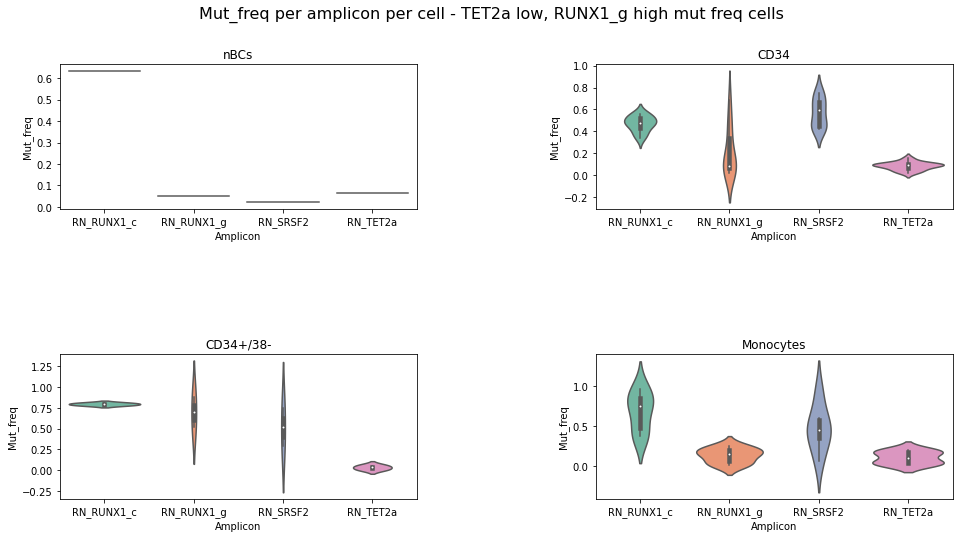

In [493]:
#Plot wells by cell type, TET2a low and RUNX1_c high cells only
fig, ax = plt.subplots(2,2, figsize = (16, 8))
fig.subplots_adjust(hspace = 1, wspace=.5)
ax = ax.ravel()

count = -1

for cell in celltypes:
    count = count + 1
    ax[count] = sns.violinplot(x='Amplicon', y='Mut_freq', data=test5[test5['Plate_Well'].isin(TET2a_h_RUNX1_c_l)].loc[test5['Cell_type'].isin([cell])], ax = ax[count], palette = 'Set2')
    ax[count].set_title(str(cell))
    
fig.suptitle('Mut_freq per amplicon per cell - TET2a low, RUNX1_g high mut freq cells', fontsize=16)
fig.savefig('../Results/Geno_counts/T2_h_R1_l_mut_freq_per_amplicon.png',dpi=600)  

#plt.close() #Plot just goes to file and isn't displayed          




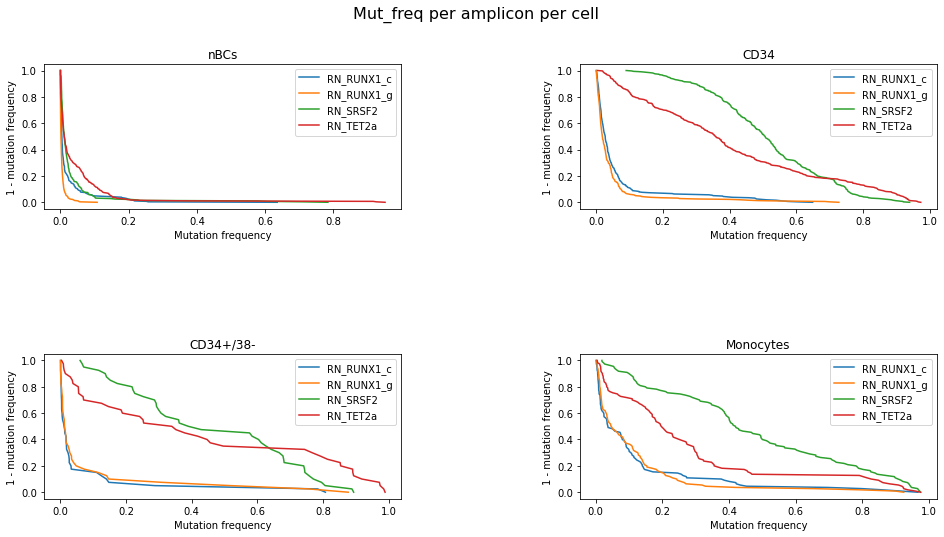

In [561]:
#Fabio suggested trying cumulative plots
RN_amplicons = test5['Amplicon'].drop_duplicates().to_list()


fig, ax = plt.subplots(2,2, figsize = (16, 8))
fig.subplots_adjust(hspace = 1, wspace=.5)
ax = ax.ravel()
count = -1

for cell in celltypes:
    
    count += 1

    for amp in RN_amplicons:

        x = np.sort(test5.loc[test5['Cell_type'].isin([cell])].loc[test5['Amplicon'].isin([amp])]['Mut_freq'])
        y = 1.0 - np.linspace(0, 1, len(x))
        ax[count].plot(x, y, label = amp)
        ax[count].set_title(str(cell))
        ax[count].set_xlabel('Mutation frequency')
        ax[count].set_ylabel('1 - mutation frequency')
        ax[count].legend()

fig.suptitle('Mut_freq per amplicon per cell', fontsize=16)
fig.savefig('../Results/Geno_counts/All_mut_freq_per_amplicon_2.png',dpi=600)  

#plt.close() #Plot just goes to file and isn't displayed    

In [562]:
#Understanding the plots
for cell in celltypes:

    for amp in RN_amplicons:
        #x = test5.loc[test5['Cell_type'].isin([cell])].loc[test5['Amplicon'].isin([amp])]['Mut_freq']
        
        x = np.sort(test5.loc[test5['Cell_type'].isin([cell])].loc[test5['Amplicon'].isin([amp])]['Mut_freq'])
        y = 1.0 - np.linspace(0, 1, len(x))
        print(y)

[1.         0.99649123 0.99298246 0.98947368 0.98596491 0.98245614
 0.97894737 0.9754386  0.97192982 0.96842105 0.96491228 0.96140351
 0.95789474 0.95438596 0.95087719 0.94736842 0.94385965 0.94035088
 0.93684211 0.93333333 0.92982456 0.92631579 0.92280702 0.91929825
 0.91578947 0.9122807  0.90877193 0.90526316 0.90175439 0.89824561
 0.89473684 0.89122807 0.8877193  0.88421053 0.88070175 0.87719298
 0.87368421 0.87017544 0.86666667 0.86315789 0.85964912 0.85614035
 0.85263158 0.84912281 0.84561404 0.84210526 0.83859649 0.83508772
 0.83157895 0.82807018 0.8245614  0.82105263 0.81754386 0.81403509
 0.81052632 0.80701754 0.80350877 0.8        0.79649123 0.79298246
 0.78947368 0.78596491 0.78245614 0.77894737 0.7754386  0.77192982
 0.76842105 0.76491228 0.76140351 0.75789474 0.75438596 0.75087719
 0.74736842 0.74385965 0.74035088 0.73684211 0.73333333 0.72982456
 0.72631579 0.72280702 0.71929825 0.71578947 0.7122807  0.70877193
 0.70526316 0.70175439 0.69824561 0.69473684 0.69122807 0.6877

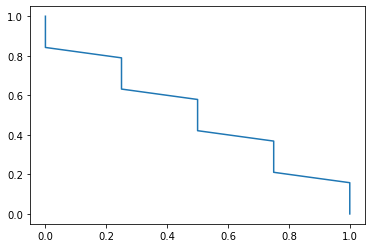

In [563]:
fig, ax = plt.subplots()
x = [0,0,0,0,0.25,0.25,0.25,0.25,0.5,0.5,0.5,0.5,0.75,0.75,0.75,0.75,1,1,1,1,]
y = 1.0 - np.linspace(0, 1, len(x))
ax.plot(x, y)

In [ ]:
#Would frequency histograms help here?


Text(0.5, 1.0, 'All cells')

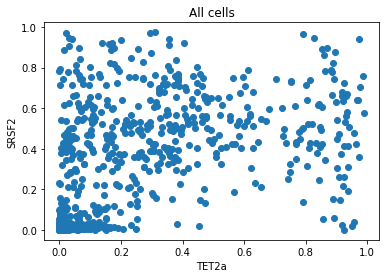

In [548]:
#Trying some pairwise comparisons
fig, ax = plt.subplots()


x = test5.loc[test5['Amplicon'].isin(['RN_TET2a'])]['Mut_freq']
y = test5.loc[test5['Amplicon'].isin(['RN_SRSF2'])]['Mut_freq']


ax.scatter(x,y)
ax.set_xlabel('TET2a')
ax.set_ylabel('SRSF2')
ax.set_title('All cells')

In [512]:
RN_amplicons

['RN_RUNX1_c', 'RN_RUNX1_g', 'RN_SRSF2', 'RN_TET2a']